In [6]:
import numpy as np
import cv2
import sys
import os
from PIL import Image
from matplotlib import pyplot as plt
from os import path, makedirs
from importlib import reload
from stitching import Stitcher
from stitching import AffineStitcher


# Seccion Stitching

In [3]:
from stitching_per.stitching.stitcher import AffineStitcher

In [7]:
def load_and_resize_images(folder, new_width):
    images = []
    filenames = ["0002.jpg", "0003.jpg", "0004.jpg"]
    #filenames = ["0001.jpg", "0002.jpg", "0003.jpg"]
    for filename in filenames:
        filepath = os.path.join(folder, filename)
        img = cv2.imread(filepath)
        if img is None:
            print(f"Error al cargar la imagen: {filename}. Saltando.")
            continue
        new_size = (new_width, int(img.shape[0] * new_width / img.shape[1]))
        img = cv2.resize(img, new_size, interpolation=cv2.INTER_AREA)
        images.append(img)
    return images

In [8]:
folder        = "./input/138/1/original"

new_width     = 6000

images_affine = load_and_resize_images(folder, new_width)
print(images_affine[0].shape)

(4000, 6000, 3)


In [9]:
##Stitcher con metodo Affine
settings = {"confidence_threshold": 0.4}
stitcher_affine = AffineStitcher(**settings)

images_rotAff = []
for image in images_affine:
    rotated = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    images_rotAff.append(rotated)
panorama_affine = stitcher_affine.stitch(images_rotAff)

(6228, 5825, 3)


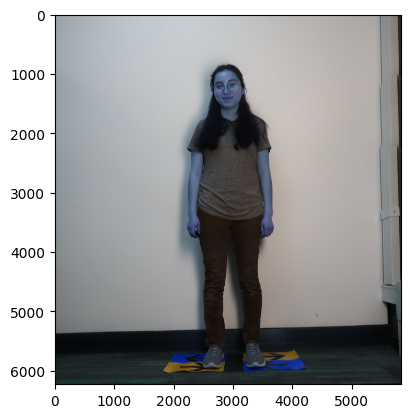

In [10]:
panorama_affine = cv2.rotate(panorama_affine, cv2.ROTATE_90_CLOCKWISE )
plt.imshow(panorama_affine)
print(panorama_affine.shape)

In [8]:
!nvidia-smi

Fri Dec 27 15:04:28 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.256.02   Driver Version: 470.256.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   56C    P8    10W /  N/A |    388MiB /  5946MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Segmentación


In [9]:
from ultralytics import YOLOWorld, SAM
import numpy as np
import torch
import gc
from scipy.ndimage import binary_fill_holes
from PIL import Image
import cv2

In [10]:
def segmentacion_pose(img_array: np.ndarray) -> np.ndarray:
    torch.cuda.empty_cache()
    
    world_model = YOLOWorld('yolov8m-world.pt')
    world_model.set_classes(["person", "clothes", "underwear"])
    world_model.to('cuda')
    with torch.cuda.amp.autocast():
        world_results = world_model(img_array, imgsz=640)
    del world_model
    gc.collect()
    torch.cuda.empty_cache()
    
    sam_model = SAM('sam2.1_b.pt')
    sam_model.to('cuda')
    mask_total = np.zeros(img_array.shape[:2], dtype=np.uint8)

    for r in world_results:
        if r.boxes is not None:
            for box in r.boxes:
                bbox = box.xyxy[0].cpu().numpy()
                with torch.cuda.amp.autocast():
                    sam_results = sam_model(
                        source=img_array,
                        bboxes=[bbox.tolist()],
                        save=False,
                        conf=0.4
                    )
                mask = sam_results[0].masks.data.cpu().numpy()[0]
                mask_bool = mask.astype(bool)
                filled_mask = binary_fill_holes(mask_bool)
                filled_mask_uint8 = filled_mask.astype(np.uint8) * 255
                mask_total = np.maximum(mask_total, filled_mask_uint8)

    sam_model.cpu()
    del sam_model
    gc.collect()
    torch.cuda.empty_cache()

    alpha_mask = mask_total
    img_with_alpha = np.dstack((img_array, alpha_mask))

    return img_with_alpha

In [11]:
img_with_alpha = segmentacion_pose(panorama_affine)
img_with_alpha_pil = Image.fromarray(img_with_alpha, mode='RGBA')


0: 640x608 1 person, 317.1ms
Speed: 8.6ms preprocess, 317.1ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 608)

0: 1024x1024 1 0, 193.9ms
Speed: 17.1ms preprocess, 193.9ms inference, 9.2ms postprocess per image at shape (1, 3, 1024, 1024)


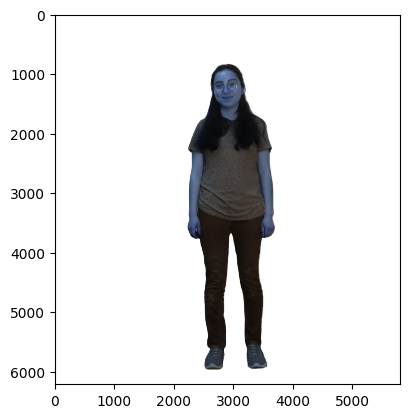

In [12]:
plt.imshow(img_with_alpha_pil)

In [13]:
!nvidia-smi

Fri Dec 27 15:05:16 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.256.02   Driver Version: 470.256.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   56C    P8    10W /  N/A |   1831MiB /  5946MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Modelo Zoe

In [14]:
from zoedepth.models.builder import build_model
from zoedepth.utils.config import get_config
from zoedepth.utils.geometry import depth_to_points
 
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [15]:
def select_points(image_array):
    """
    original_img = cv2.imread(image_path)
    if original_img is None:
        raise FileNotFoundError(f"No se encontro la imagen en {image_path}.")
    """
    height, width = image_array.shape[:2]
    max_dimension = 800
    scale = min(max_dimension/width, max_dimension/height)
    new_width = int(width * scale)
    new_height = int(height * scale)
    
    img = cv2.resize(image_array, (new_width, new_height))
    points = []
    scale_factor = (width/new_width, height/new_height)
    
    def mouse_callback(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            original_x = int(x * scale_factor[0])
            original_y = int(y * scale_factor[1])
            points.append((original_x, original_y))
            cv2.circle(img, (x, y), 5, (0, 0, 255), -1)
            cv2.imshow('Image', img)
    
    cv2.imshow('Image', img)
    cv2.setMouseCallback('Image', mouse_callback)
    
    print("Selecciona los puntos en la imagen (Apretar 'q' cuando termine)")
    while True:
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break
    
    cv2.destroyAllWindows()
    return points

def process_image_with_points(image_array, model_name="zoedepth", mask_image=None):
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {DEVICE}")

    conf = get_config(model_name, "infer")
    model = build_model(conf).to(DEVICE)
    model.eval()

    # Seleccionar puntos 2D
    points_2d = select_points(image_array)

    # Convertir imagen a formato PIL
    img = Image.fromarray(image_array).convert("RGB")
    img_np = np.array(img)
    H, W = img_np.shape[:2]

    # Preparar mascara
    if mask_image is not None:
        mask_img = mask_image.convert("RGBA")
        if mask_img.size != img.size:
            mask_img = mask_img.resize(img.size, Image.NEAREST)
        _, _, _, a = mask_img.split()
        mask_np = np.array(a)
        mask = (mask_np > 0)
    else:
        mask = np.ones((H, W), dtype=bool)

    print(f"Imagen: {H}x{W}")
    print(f"Máscara: {mask.shape}, puntos válidos: {np.sum(mask)}")

    with torch.no_grad():
        depth = model.infer_pil(img)
    
    ### Conversion profundidad a puntos 3D
    points_3d = depth_to_points(depth[None])

    points_all = points_3d.reshape(-1, 3)
    colors_all = img_np.reshape(-1, 3) / 255.0
    mask_flat = mask.flatten()

    ### Filtrar puntos por mascara
    points_filtered = points_all[mask_flat]
    colors_filtered = colors_all[mask_flat]

    print(f"Puntos totales: {points_all.shape[0]}")
    print(f"Puntos filtrados: {points_filtered.shape[0]}")

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points_filtered.astype(np.float32))
    pcd.colors = o3d.utility.Vector3dVector(colors_filtered.astype(np.float32))
    
    highlighted_points = []
    for x, y in points_2d:
        if 0 <= x < W and 0 <= y < H:
            idx = y * W + x
            if mask_flat[idx]:
                highlighted_points.append(points_all[idx])

    vis = o3d.visualization.Visualizer()
    vis.create_window(width=1280, height=720)
    
    ### Visualizacion de puntos 3D
    vis.add_geometry(pcd)
    
    if highlighted_points:
        highlighted_pcd = o3d.geometry.PointCloud()
        highlighted_pcd.points = o3d.utility.Vector3dVector(np.array(highlighted_points))
        highlighted_colors = np.array([[1, 0, 0] for _ in highlighted_points])
        highlighted_pcd.colors = o3d.utility.Vector3dVector(highlighted_colors)
        vis.add_geometry(highlighted_pcd)
        
        for hp in highlighted_points:
            sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.01)
            sphere.translate(hp)
            sphere.paint_uniform_color([1, 0, 0])
            vis.add_geometry(sphere)
    
    camera_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.3)
    vis.add_geometry(camera_frame)
    
    camera_pos = o3d.geometry.TriangleMesh.create_sphere(radius=0.05)
    camera_pos.paint_uniform_color([0, 1, 0])
    vis.add_geometry(camera_pos)
    
    camera_direction = o3d.geometry.TriangleMesh.create_cone(radius=0.05, height=0.1)
    R = camera_direction.get_rotation_matrix_from_xyz((0, np.pi/2, 0))
    camera_direction.rotate(R, center=(0, 0, 0))
    camera_direction.paint_uniform_color([0, 0, 1])
    vis.add_geometry(camera_direction)
    
    opt = vis.get_render_option()
    opt.point_size = 1.0
    opt.background_color = np.asarray([0, 0, 0])
    
    ctr = vis.get_view_control()
    ctr.set_zoom(0.3)
    ctr.set_front([0, 0, -1])
    ctr.set_up([0, 1, 0])
    
    vis.run()
    vis.destroy_window()

In [17]:
!nvidia-smi

Fri Dec 27 15:05:49 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.256.02   Driver Version: 470.256.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   54C    P8    10W /  N/A |   1831MiB /  5946MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [18]:
process_image_with_points(panorama_affine, "zoedepth", img_with_alpha_pil) 

Using device: cuda
img_size [384, 512]


Using cache found in /home/seba2411/.cache/torch/hub/intel-isl_MiDaS_master
/home/seba2411/miniconda3/envs/zoe/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_N.pt
Loaded successfully
Selecciona los puntos en la imagen (Apretar 'q' cuando termine)
Imagen: 6212x5809
Máscara: (6212, 5809), puntos válidos: 4740202


: 

In [ ]:
!nvidia-smi